# 수입 우범화물 선별 기초 - XGBoost 모델

# 1. 분석 환경 설정 및 데이터 로딩<a id='id1'></a> 

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [2]:
# 모델 구현 시간 체크
import time
# 시작시간 체크
start = time.time()

In [3]:
# 패키지 로딩
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import math

# 화면 디스플레이 전체 구간을 넓게
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 999) # pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 999) # pd.options.display.max_columns = 999
pd.set_option('display.width', 1000)

# 한글폰트 적용
plt.rc('font', family='NanumBarunGothic')
%matplotlib inline

In [4]:
# 수입 데이터 로딩 (가상데이터)
df_org = pd.read_csv('/train_and_test.csv',encoding='cp949')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# 우범여부가 1인 데이터(우범) 필터링
isCriminal = df_org['우범여부'] == 1
Criminal = df_org[isCriminal]

In [6]:
# 우범여부가 0인 데이터(정상) 필터링
isNonCriminal = df_org['우범여부'] == 0
NonCriminal = df_org[isNonCriminal]

In [7]:
# 신고일자를 2-class로 변경
# 날짜를 월별로 4~9월은 1로 매칭, 1~3월과 10~12월은 0으로 매칭
def change_date(arr):
  for i, val in enumerate(arr.index):
    month = (int)(arr[val].split('-')[1])
    if month >= 4 and month <=9:
      arr[val] = 1
    else:
      arr[val] = 0
  return arr

In [8]:
# 우범데이터와 정상데이터의 비율에 따라 데이터 값을 구분함
# 우범데이터와 정상데이터의 비율이 0.5 이상인 값, 0.3 이상인 값, 0.2 이상인 값, 그 외의 값을 구분해 따로 리스트에 저장
def calc_gap(c, nc):
  gap1 = []
  gap2 = []
  gap3 = []
  gap4 = []

  for i, val in enumerate(c.index):
    if (val in c.index) and (val in nc.index):
      if c[val]/(c[val]+nc[val]) >= 0.5:
        gap1.append(val)
      elif c[val]/(c[val]+nc[val]) >= 0.3:
        gap2.append(val)
      elif c[val]/(c[val]+nc[val]) >= 0.2:
        gap3.append(val)
      else:
        gap4.append(val)
    else:
      gap4.append(val)
  return gap1, gap2, gap3, gap4

In [9]:
# 비율에 따라 구분된 데이터 리스트로 실제 데이터 값을 바꿔줌
# 예를 들어, gap1=[100,102,103]이라면 실제 데이터 100, 102, 103을 1로 바꿔줌
def change_gap_code(arr, gap1, gap2, gap3, gap4):
  for i, val in enumerate(gap1):
    arr.loc[arr[:] == val] = 1
  for i, val in enumerate(gap2):
    arr.loc[arr[:] == val] = 2
  for i, val in enumerate(gap3):
    arr.loc[arr[:] == val] = 3
  for i, val in enumerate(gap4):
    arr.loc[arr[:] == val] = 4
  arr.loc[((arr[:] == 1) | (arr[:] == 2) | (arr[:] == 3) | (arr[:] == 4)) == False] = 4
  return arr

In [10]:
# calc_gap + change_gap_code
# 비율별로 데이터를 구분하고 데이터 값을 그에 맞게 변경
def change_gap_code_main(col_name):
  df_org[col_name] = df_org[col_name].fillna('Mssing')

  isCriminal = df_org['우범여부'] == 1
  Criminal = df_org[isCriminal]

  isNonCriminal = df_org['우범여부'] == 0
  NonCriminal = df_org[isNonCriminal]

  c1 = Criminal[col_name].value_counts().sort_index(ascending=True)
  nc1 = NonCriminal[col_name].value_counts().sort_index(ascending=True)

  gap1, gap2, gap3, gap4 = calc_gap(c1, nc1)

  df_org[col_name] = change_gap_code(df_org[col_name], gap1, gap2, gap3, gap4)

In [11]:
# 신고일자에 대한 우범 데이터
tmp_Criminal = Criminal['신고일자']
tmp_Criminal = change_date(tmp_Criminal)
print(tmp_Criminal.value_counts())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  im

1    11256
0     6316
Name: 신고일자, dtype: int64


In [12]:
# 신고 일자에 대한 정상 데이터
tmp_NonCriminal = NonCriminal['신고일자']
tmp_NonCriminal = change_date(tmp_NonCriminal)
print(tmp_NonCriminal.value_counts())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


1    36974
0    22291
Name: 신고일자, dtype: int64


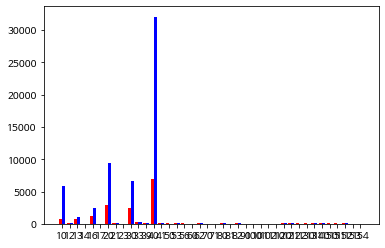

In [13]:
# 통관지세관부호에 대한 우범, 정상 데이터
c1 = Criminal['통관지세관부호'].value_counts().sort_index(ascending=True)
nc1 = NonCriminal['통관지세관부호'].value_counts().sort_index(ascending=True)

plt.bar(np.arange(len(nc1))-0.2, c1, color='r', width=0.4)
plt.bar(np.arange(len(nc1))+0.2, nc1, color='b', width=0.4)
plt.xticks(np.arange(len(c1)), c1.index)
plt.show()


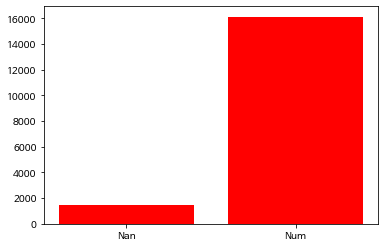

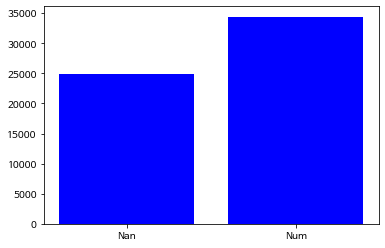

In [14]:
# 해외거래처부호 유무에 대한 우범, 정상 데이터
x=['Nan', 'Num']
y1 = [Criminal['해외거래처부호'].isna().sum(), len(Criminal['해외거래처부호']) - Criminal['해외거래처부호'].isna().sum()]
y2 = [NonCriminal['해외거래처부호'].isna().sum(), len(NonCriminal['해외거래처부호']) - NonCriminal['해외거래처부호'].isna().sum()]
plt.bar([0,1], y1, color='r')
plt.xticks(np.arange(2), x)
# plt.title('우범일 때 해외거래처부호 유무')
plt.show()
plt.bar([0,1], y2, color='b')
plt.xticks(np.arange(2), x)
# plt.title('정상일 때 해외거래처부호 유무')
plt.show()

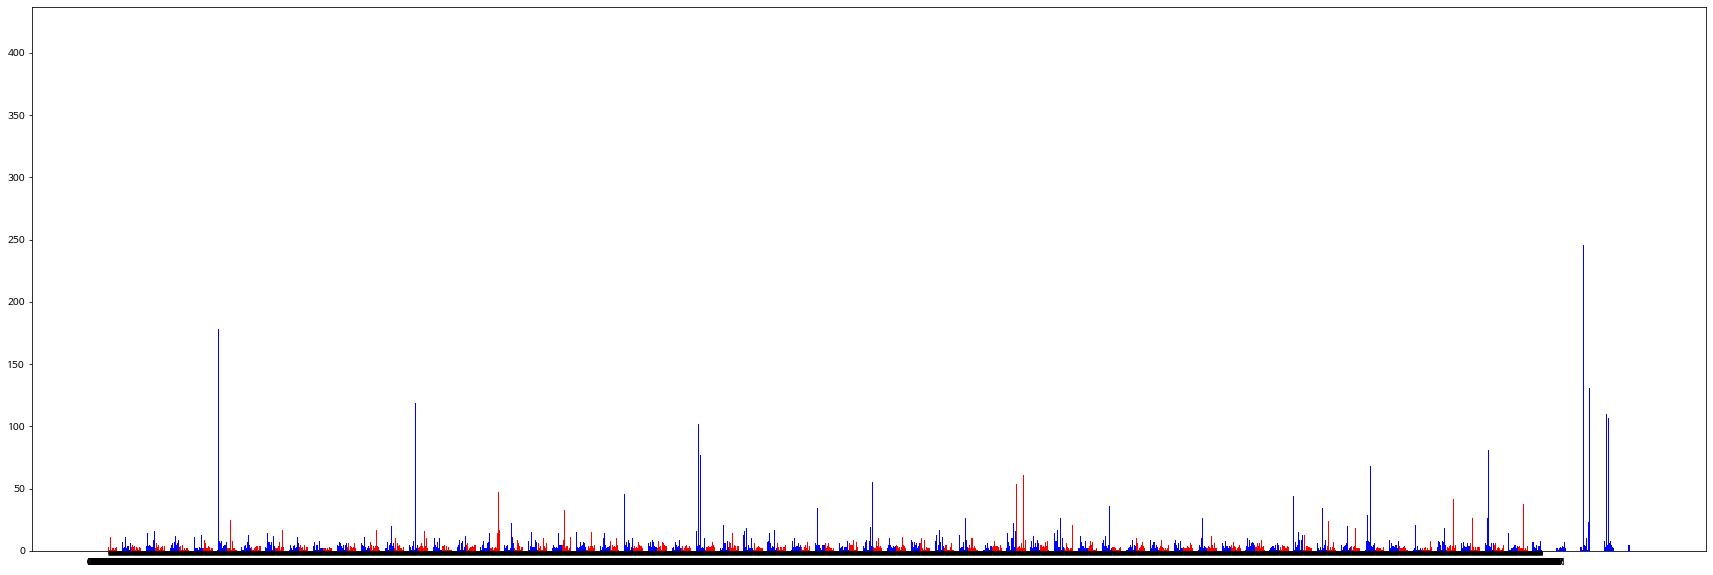

In [15]:
# 해외거래처부호에 대한 우범, 정상 데이터

c1 = Criminal['해외거래처부호'].value_counts().sort_index(ascending=True)
nc1 = NonCriminal['해외거래처부호'].value_counts().sort_index(ascending=True)
plt.figure(figsize=(30, 10))
plt.bar(np.arange(len(c1))-0.2, c1, color='r', width=0.4)
plt.bar(np.arange(len(nc1))+0.2, nc1, color='b', width=0.4)
plt.xticks(np.arange(len(c1)), c1.index)
plt.show()


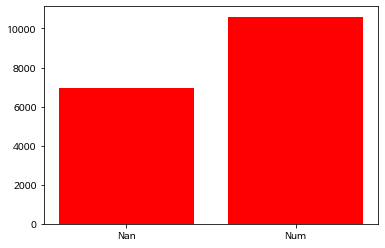

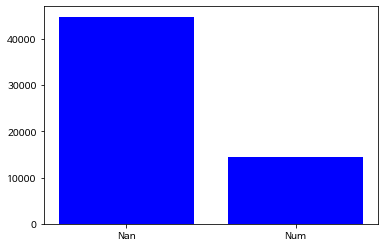

In [16]:
# 특송업체부호 유무에 대한 우범, 정상 데이터
x=['Nan', 'Num']
y1 = [Criminal['특송업체부호'].isna().sum(), len(Criminal['특송업체부호']) - Criminal['특송업체부호'].isna().sum()]
y2 = [NonCriminal['특송업체부호'].isna().sum(), len(NonCriminal['특송업체부호']) - NonCriminal['특송업체부호'].isna().sum()]
plt.bar([0,1], y1, color='r')
plt.xticks(np.arange(2), x)
# plt.title('우범일 때 특송업체부호 유무')
plt.show()
plt.bar([0,1], y2, color='b')
plt.xticks(np.arange(2), x)
# plt.title('정상일 때 특송업체부호 유무')
plt.show()

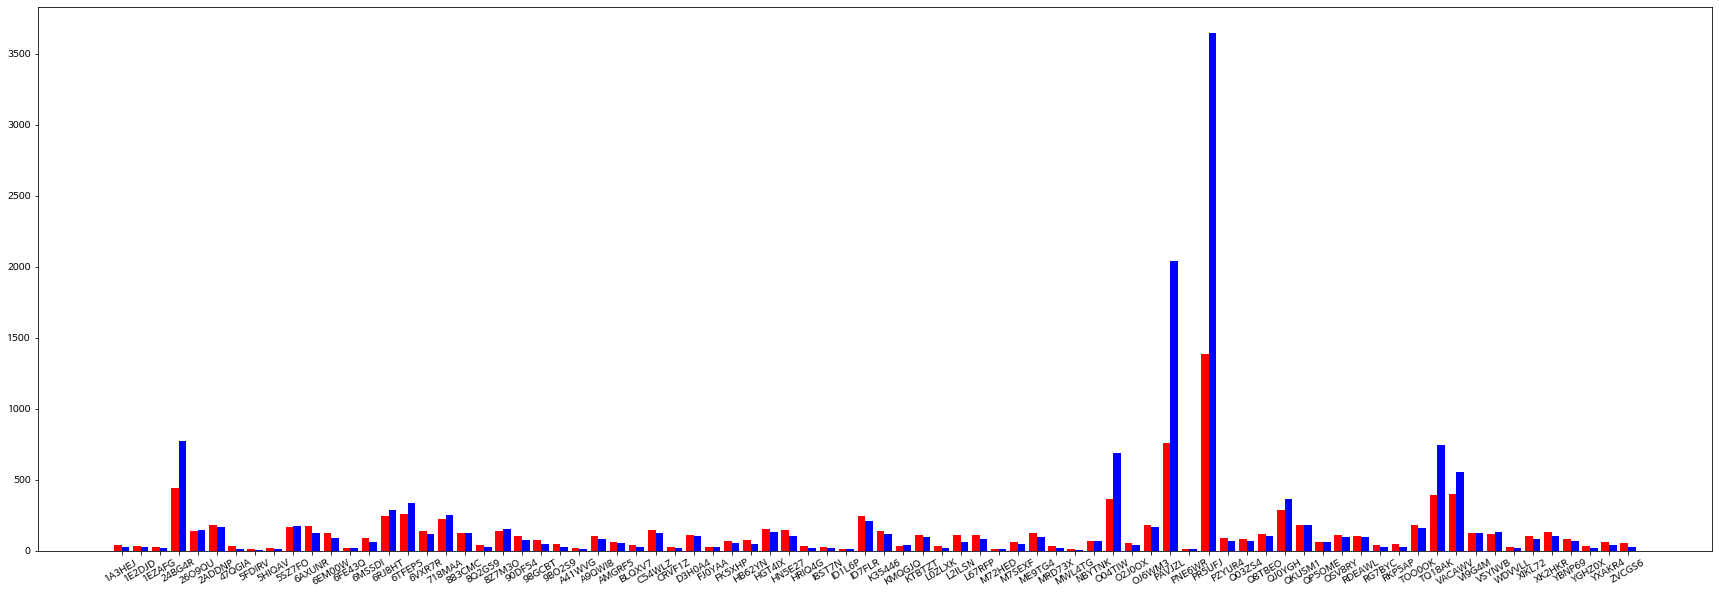

In [17]:
# 특송업체부호에 대한 우범, 정상 데이터
c1 = Criminal['특송업체부호'].value_counts().sort_index(ascending=True)
nc1 = NonCriminal['특송업체부호'].value_counts().sort_index(ascending=True)
plt.figure(figsize=(30, 10))
plt.bar(np.arange(len(nc1))-0.2, c1, color='r', width=0.4)
plt.bar(np.arange(len(nc1))+0.2, nc1, color='b', width=0.4)
plt.xticks(np.arange(len(c1)), c1.index)
plt.xticks(rotation =30)
plt.show()

In [18]:
# #수입통관계획코드에 대한 우범, 정상 데이터

# c1 = Criminal['수입통관계획코드'].value_counts().sort_index(ascending=True)
# nc1 = NonCriminal['수입통관계획코드'].value_counts().sort_index(ascending=True)

# x= ['B', 'C', 'D','E','F','H','Z']

# plt.bar(range(len(x)), c1, color='r', width=0.5)
# plt.xticks(np.arange(7), x)
# plt.show()

# plt.bar(range(len(x)), nc1, color='b', width=0.5)
# plt.xticks(np.arange(7), x)
# plt.show()

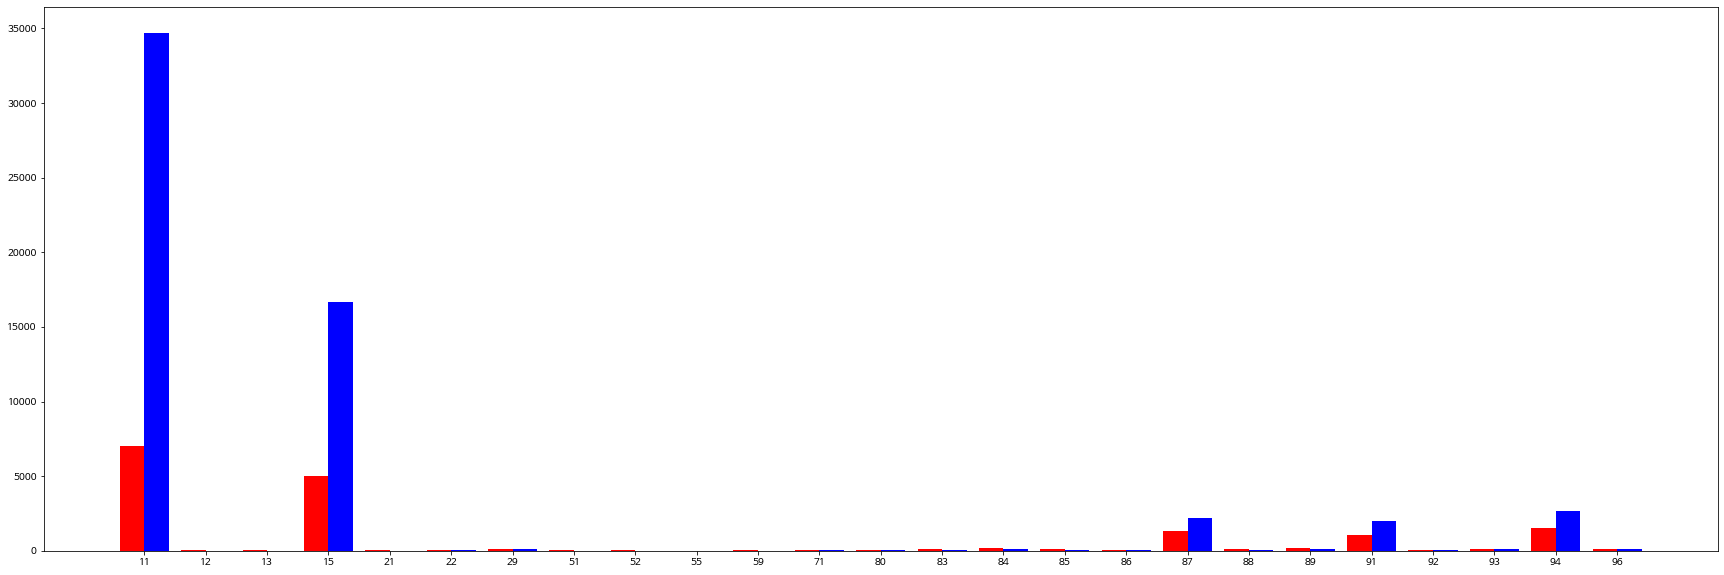

In [19]:
# 수입거래구분코드에 대한 우범, 정상 데이터 확인
c1 = Criminal['수입거래구분코드'].value_counts().sort_index(ascending=True)
nc1 = NonCriminal['수입거래구분코드'].value_counts().sort_index(ascending=True)

plt.figure(figsize=(30, 10))
plt.bar(np.arange(len(c1))-0.2, c1, color='r', width=0.4)
plt.bar(np.arange(len(nc1))+0.2, nc1, color='b', width=0.4)
plt.xticks(np.arange(len(c1)), c1.index)
plt.show()

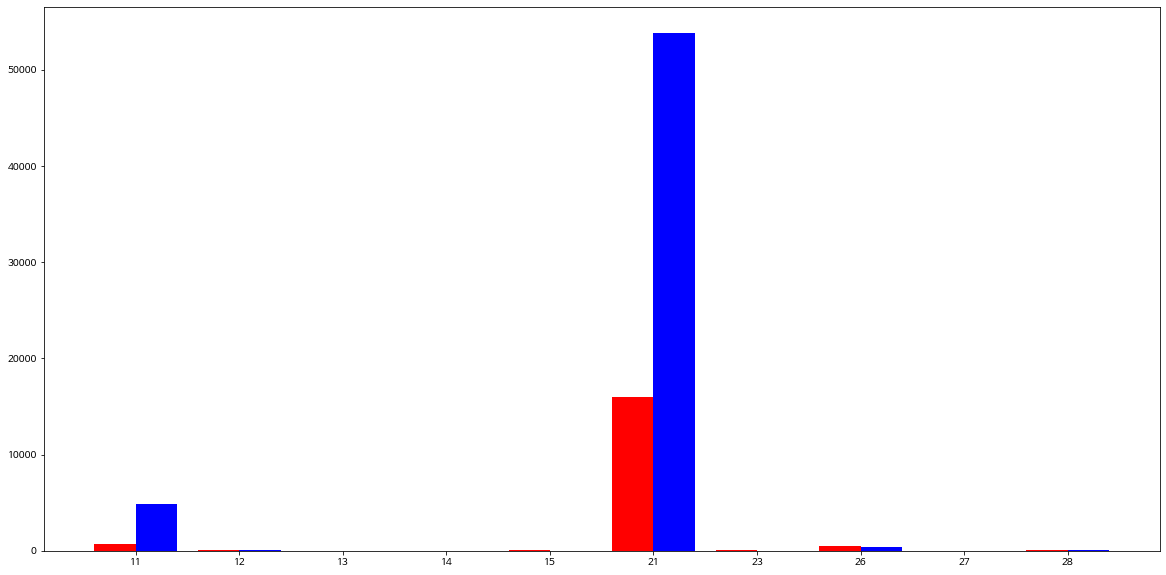

In [20]:
# 수입종류코드에 대한 우범, 정상 데이터
c1 = Criminal['수입종류코드'].value_counts().sort_index(ascending=True)
nc1 = NonCriminal['수입종류코드'].value_counts().sort_index(ascending=True)

plt.figure(figsize=(20, 10))
plt.bar(np.arange(len(c1))-0.2, c1, color='r', width=0.4)
plt.bar(np.arange(len(nc1))+0.2, nc1, color='b', width=0.4)
plt.xticks(np.arange(len(c1)), c1.index)
plt.show()

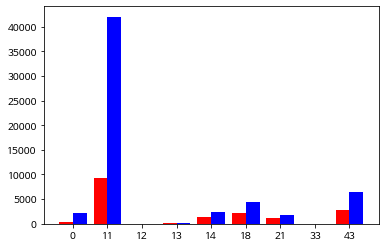

In [21]:
# 징수형태코드에 대한 우범, 정상 데이터
c1 = Criminal['징수형태코드'].value_counts().sort_index(ascending=True)
nc1 = NonCriminal['징수형태코드'].value_counts().sort_index(ascending=True)

# plt.figure(figsize=(20, 10))
plt.bar(np.arange(len(c1))-0.2, c1, color='r', width=0.4)
plt.bar(np.arange(len(nc1))+0.2, nc1, color='b', width=0.4)
plt.xticks(np.arange(len(c1)), c1.index)
plt.show()

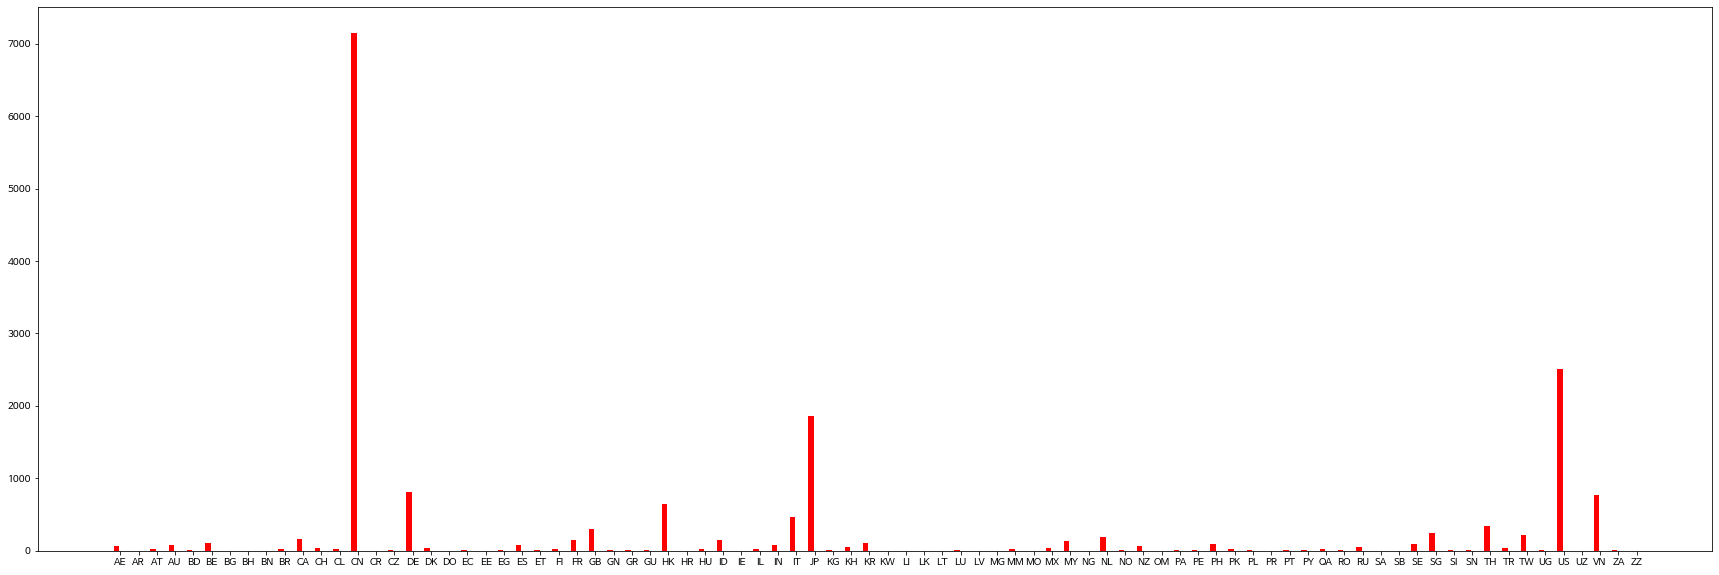

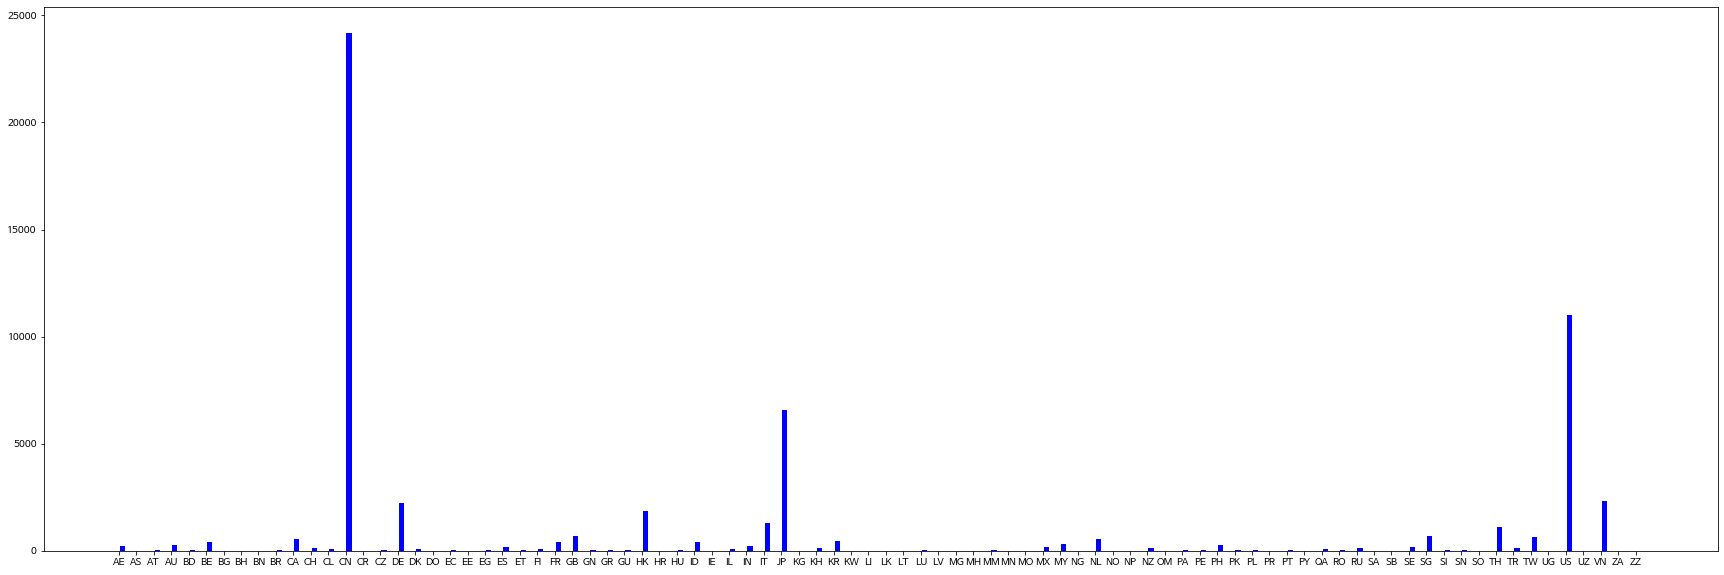

In [22]:
# 적출국가코드에 대한 우범, 정상 데이터
c1 = Criminal['적출국가코드'].value_counts().sort_index(ascending=True)
nc1 = NonCriminal['적출국가코드'].value_counts().sort_index(ascending=True)

plt.figure(figsize=(30, 10))
plt.bar(np.arange(len(c1))-0.2, c1, color='r', width=0.3)
# plt.bar(np.arange(len(nc1))+0.2, nc1, color='b', width=0.3)
# plt.tick_params(width = 1.2)
plt.xticks(np.arange(len(c1)), c1.index)
plt.show()
plt.figure(figsize=(30, 10))

plt.bar(np.arange(len(nc1))+0.2, nc1, color='b', width=0.3)
plt.xticks(np.arange(len(nc1)), nc1.index)
plt.show()

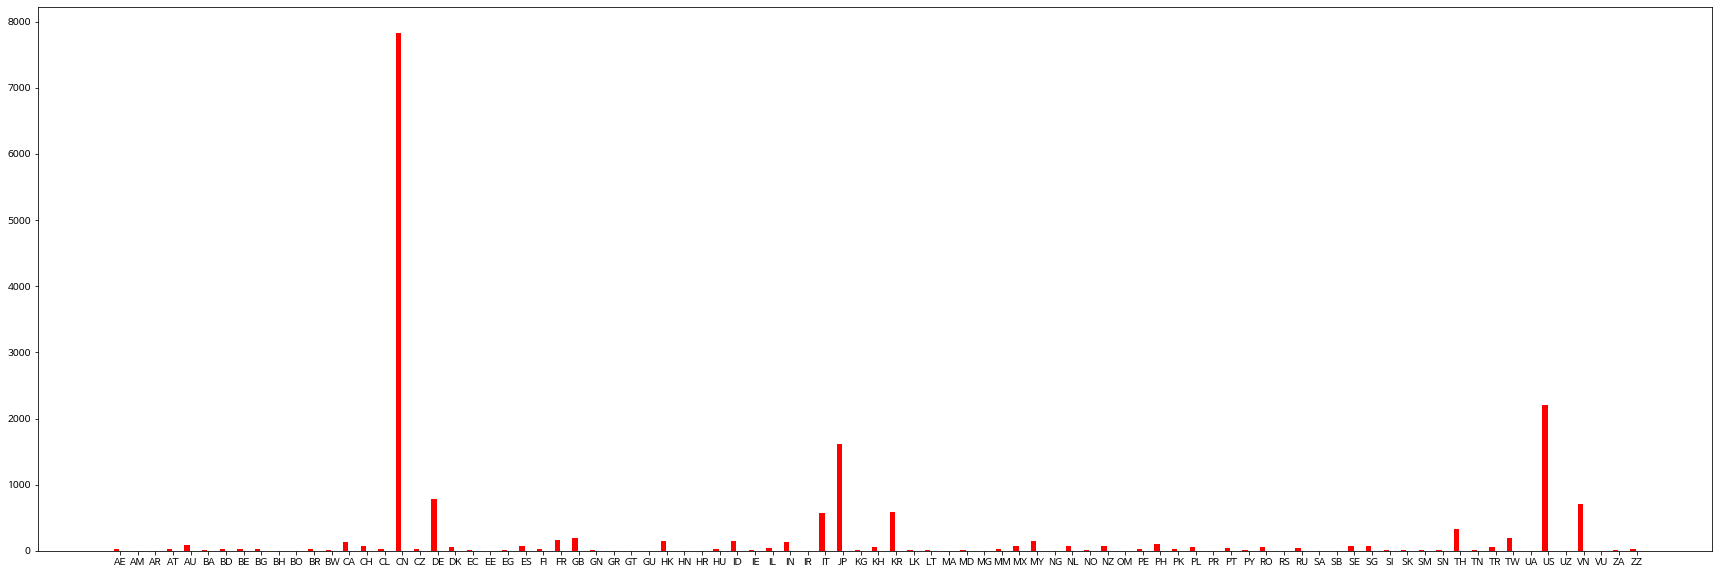

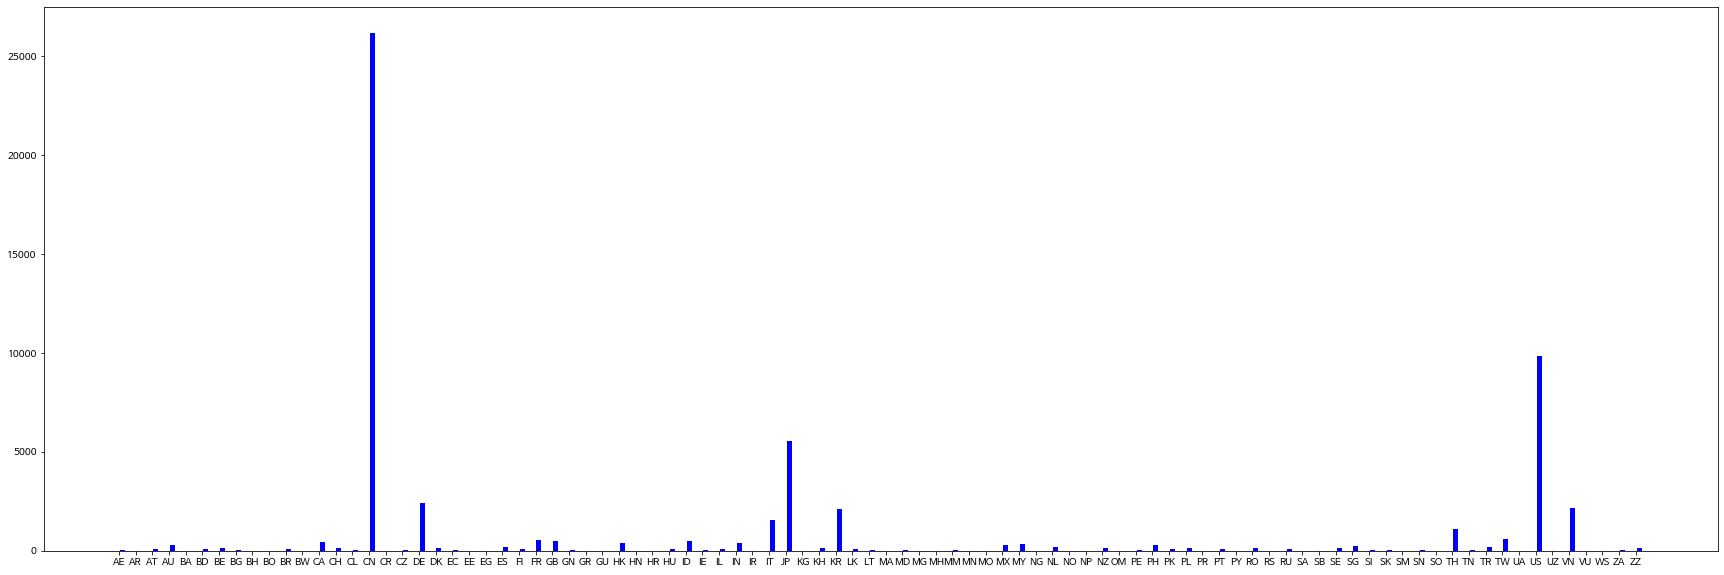

In [23]:
# 원산지국가코드에 대한 우범, 정상 데이터
c1 = Criminal['원산지국가코드'].value_counts().sort_index(ascending=True)
nc1 = NonCriminal['원산지국가코드'].value_counts().sort_index(ascending=True)

plt.figure(figsize=(30, 10))
plt.bar(np.arange(len(c1))-0.2, c1, color='r', width=0.3)
# plt.bar(np.arange(len(nc1))+0.2, nc1, color='b', width=0.3)
# plt.tick_params(width = 1.2)
plt.xticks(np.arange(len(c1)), c1.index)
plt.show()
plt.figure(figsize=(30, 10))

plt.bar(np.arange(len(nc1))+0.2, nc1, color='b', width=0.3)
plt.xticks(np.arange(len(nc1)), nc1.index)
plt.show()

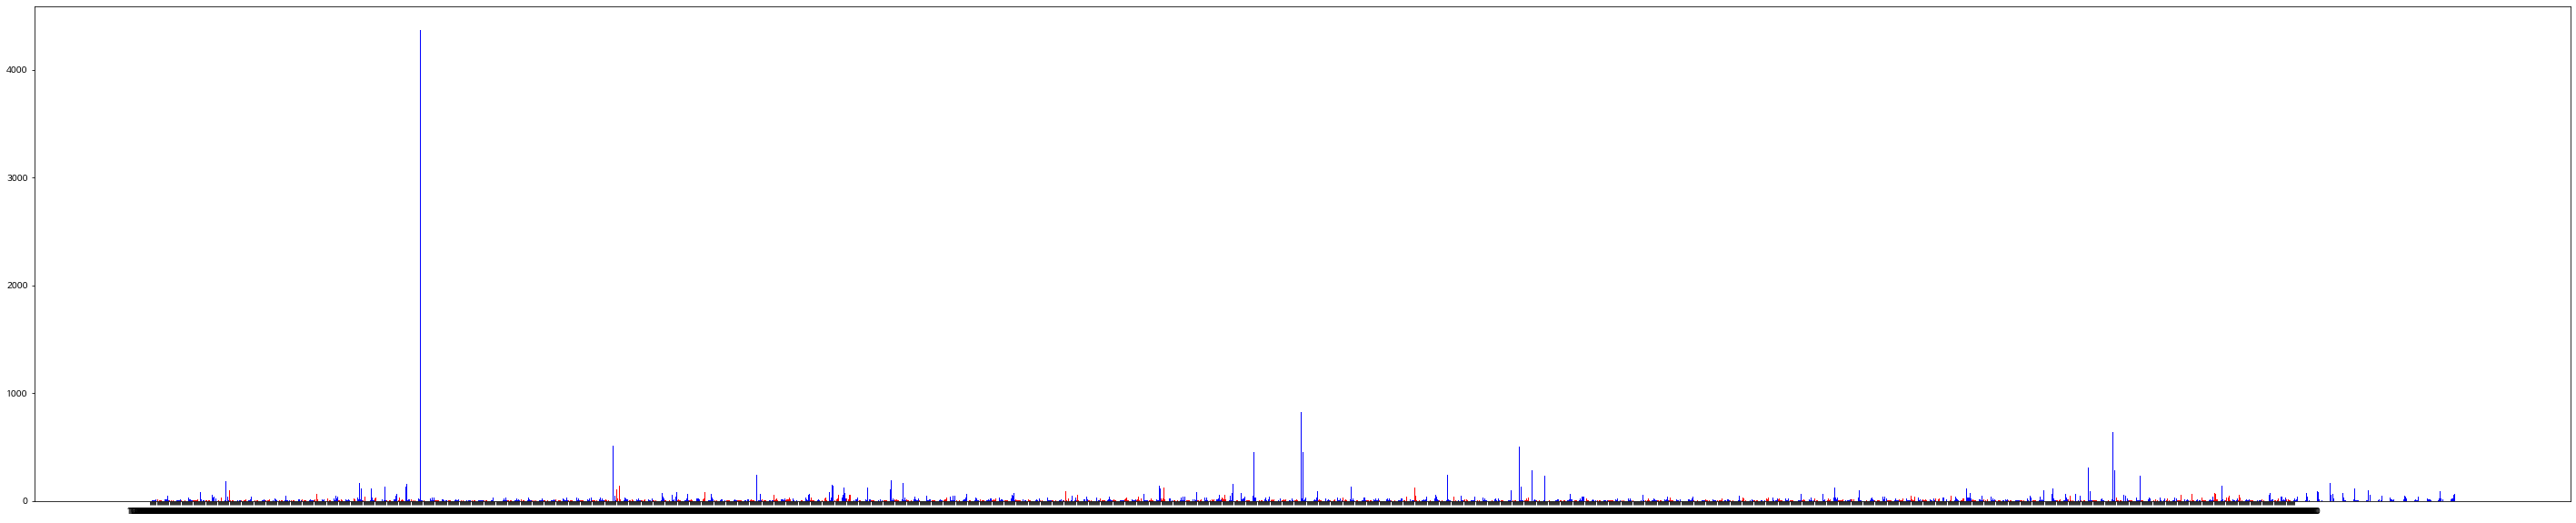

In [24]:
# HS10단위부호에 대한 우범, 정상 데이터

c1 = Criminal['HS10단위부호'].value_counts().sort_index(ascending=True)
nc1 = NonCriminal['HS10단위부호'].value_counts().sort_index(ascending=True)

plt.figure(figsize=(50, 10))
plt.bar(np.arange(len(c1))-0.2, c1, color='r', width=0.4)
plt.bar(np.arange(len(nc1))+0.2, nc1, color='b', width=0.4)
plt.xticks(np.arange(len(c1)), c1.index)
plt.show()

# 2. 데이터 전처리 <a id='id2'></a>

## 2.1. 전처리 기본(수치형 변수 및 범주형 변수 지정 등)

In [25]:
# 데이터 사이즈 확인
df_org.shape

(100000, 24)

In [26]:
# 데이터 샘플 3개 확인
df_org.sample(3)

,신고번호,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,검사결과코드,우범여부,핵심적발
23419,63924040,2020-03-12,40,2EO6C,8H2P4O1,ZM1NLI5,PR5UFJ,F,B,11,21,43,17182.5,3.197897e+06,40,1351002,8213009000,JP,TW,A,8.0,A,0.0,0.0
47537,31292752,2020-06-10,30,4WDK6,R2HNPW2,ZGF7GUV,NaN,F,B,11,21,11,6607.9,1.258960e+03,10,3077016,2101111000,DE,DE,A,8.0,A,0.0,0.0
20797,59976024,2020-03-04,10,CGMT6,AEV4MFK,NaN,NaN,C,B,11,21,43,25097.2,8.726071e+06,40,3386006,3917400000,JP,JP,C,6.5,A,0.0,0.0


In [27]:
df_org['우범여부'].value_counts()

0.0    59265
1.0    17572
Name: 우범여부, dtype: int64

In [28]:
df_org['핵심적발'].value_counts()

0.0    59265
2.0     9049
1.0     8523
Name: 핵심적발, dtype: int64

In [29]:
# 불필요한 변수 삭제
del df_org['검사결과코드']
del df_org['핵심적발']

del df_org['수입신고구분코드']
del df_org['신고번호']
del df_org['수입종류코드']
del df_org['운송수단유형코드']
del df_org['신고인부호']
del df_org['수입자부호']

In [30]:
df_org.columns

Index(['신고일자', '통관지세관부호', '해외거래처부호', '특송업체부호', '수입통관계획코드', '수입거래구분코드', '징수형태코드', '신고중량(KG)', '과세가격원화금액', '반입보세구역부호', 'HS10단위부호', '적출국가코드', '원산지국가코드', '관세율구분코드', '관세율', '우범여부'], dtype='object')

In [31]:
df_org.shape

(100000, 16)

In [32]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   신고일자      100000 non-null  object 
 1   통관지세관부호   100000 non-null  int64  
 2   해외거래처부호   66033 non-null   object 
 3   특송업체부호    32839 non-null   object 
 4   수입통관계획코드  100000 non-null  object 
 5   수입거래구분코드  100000 non-null  int64  
 6   징수형태코드    100000 non-null  int64  
 7   신고중량(KG)  100000 non-null  float64
 8   과세가격원화금액  100000 non-null  float64
 9   반입보세구역부호  100000 non-null  int64  
 10  HS10단위부호  100000 non-null  int64  
 11  적출국가코드    100000 non-null  object 
 12  원산지국가코드   100000 non-null  object 
 13  관세율구분코드   100000 non-null  object 
 14  관세율       100000 non-null  float64
 15  우범여부      76837 non-null   float64
dtypes: float64(4), int64(5), object(7)
memory usage: 12.2+ MB


In [33]:
# 각 column의 데이터를 정상, 우범 비율로 구분한 값으로 매칭한다
change_gap_code_main('해외거래처부호')
change_gap_code_main('특송업체부호')
change_gap_code_main('HS10단위부호')
change_gap_code_main('반입보세구역부호')
change_gap_code_main('수입거래구분코드')
change_gap_code_main('통관지세관부호')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [34]:
# 신고일자 전처리
df_org['신고일자'] = change_date(df_org['신고일자'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [35]:
df_org.sample(3)

,신고일자,통관지세관부호,해외거래처부호,특송업체부호,수입통관계획코드,수입거래구분코드,징수형태코드,신고중량(KG),과세가격원화금액,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,우범여부
39634,1,1,1,1,F,2,43,4339.9,59533.4180,4,4,CN,KR,A,8.0,0.0
83331,0,3,4,4,D,4,11,5442.9,969076.9404,4,3,CN,CN,A,8.0,NaN
69810,1,4,4,4,D,4,11,9522.8,494940.3328,4,4,CN,CN,C,0.0,0.0


In [36]:
# 범주형 변수 지정
discrete_columns = ['신고일자', '통관지세관부호','수입통관계획코드',
       '수입거래구분코드','해외거래처부호', '특송업체부호',
       '징수형태코드', 'HS10단위부호', '반입보세구역부호',
       '적출국가코드', '원산지국가코드', '관세율구분코드']

# 범주형 변수들을 문자열로 지정 ('object' -> 'string')
for var in discrete_columns:
    df_org[var] = df_org[var].astype(str)

In [37]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   신고일자      100000 non-null  object 
 1   통관지세관부호   100000 non-null  object 
 2   해외거래처부호   100000 non-null  object 
 3   특송업체부호    100000 non-null  object 
 4   수입통관계획코드  100000 non-null  object 
 5   수입거래구분코드  100000 non-null  object 
 6   징수형태코드    100000 non-null  object 
 7   신고중량(KG)  100000 non-null  float64
 8   과세가격원화금액  100000 non-null  float64
 9   반입보세구역부호  100000 non-null  object 
 10  HS10단위부호  100000 non-null  object 
 11  적출국가코드    100000 non-null  object 
 12  원산지국가코드   100000 non-null  object 
 13  관세율구분코드   100000 non-null  object 
 14  관세율       100000 non-null  float64
 15  우범여부      76837 non-null   float64
dtypes: float64(4), object(12)
memory usage: 12.2+ MB


In [38]:
# 수치형 변수 지정
numeric_columns = ['신고중량(KG)', '과세가격원화금액', '관세율', '우범여부']

# 수치형 변수를 자연로그로 변환
for var in ['신고중량(KG)', '과세가격원화금액']:
    df_org[var] = df_org[var].apply(lambda x: np.log1p(x))

In [39]:
df_org.head(5)

,신고일자,통관지세관부호,해외거래처부호,특송업체부호,수입통관계획코드,수입거래구분코드,징수형태코드,신고중량(KG),과세가격원화금액,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,우범여부
0,0,1,4,2,D,3,43,4.844187,8.593963,2,3,US,US,A,8.0,1.0
1,0,3,4,4,C,4,11,10.303820,13.258812,4,4,US,US,A,8.0,0.0
2,0,3,2,4,D,4,18,10.067242,10.862759,4,4,US,US,A,10.0,0.0
3,0,4,4,4,C,2,43,9.429564,14.388527,3,4,CN,CN,A,8.0,0.0
4,0,3,2,4,C,4,43,9.661015,15.987683,3,2,CN,CN,FCN1,5.2,1.0


## 2.2. 훈련데이터와 테스트데이터 분리 및 범주형 변수 전처리 

In [40]:
# 랜덤하게 90:10 으로 훈련 및 테스트 데이터 분리
from sklearn.model_selection import train_test_split
df_org_train, df_org_test = train_test_split(df_org[:][:76837], test_size =0.1, random_state=123)

In [41]:
# 데이터 사이즈 확인
print(df_org_train.shape, df_org_test.shape)

(69153, 16) (7684, 16)


In [42]:
df_org_for_prd = df_org[:][76837:]

In [43]:
df_org.columns

Index(['신고일자', '통관지세관부호', '해외거래처부호', '특송업체부호', '수입통관계획코드', '수입거래구분코드', '징수형태코드', '신고중량(KG)', '과세가격원화금액', '반입보세구역부호', 'HS10단위부호', '적출국가코드', '원산지국가코드', '관세율구분코드', '관세율', '우범여부'], dtype='object')

In [44]:
df_org.shape

(100000, 16)

In [45]:
# 범주형 변수 전처리 1단계: label encoding --> 각 범주형 변수가 갖는 클래스에 고유의 식별번호 부여
# 예) 수입자 상호: AAABB -> 1, 가나다라 -> 2, ...

label_encoding_ref = {}
for var in discrete_columns:
    label_encoding_ref[var] = {code: i+1 for i, code in enumerate(df_org_train[var].unique())} # 0 padding for unseen data in test
    #print(label_encoding_ref[var])
    df_org_train[var] = [label_encoding_ref[var][x] for x in df_org_train[var]]
    df_org_test[var] = [label_encoding_ref[var].get(x,0) for x in df_org_test[var]]
    df_org_for_prd[var] = [label_encoding_ref[var].get(x,0) for x in df_org_for_prd[var]]

df_org_train.reset_index(drop=True, inplace=True)
df_org_test.reset_index(drop=True, inplace=True)
df_org_for_prd.reset_index(drop=True, inplace=True)

In [46]:
# 트레인데이터 샘플 확인
df_org_train.sample(3)

,신고일자,통관지세관부호,해외거래처부호,특송업체부호,수입통관계획코드,수입거래구분코드,징수형태코드,신고중량(KG),과세가격원화금액,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,우범여부
3332,2,1,2,1,2,3,6,7.374566,12.777980,2,1,27,35,10,0.0,1.0
16801,2,1,1,1,1,2,6,8.833754,13.485832,3,1,8,8,7,0.0,0.0
24330,1,1,3,1,2,2,3,10.249259,13.204250,3,2,6,5,2,8.0,0.0


In [47]:
# 테스트데이터 샘플 확인
df_org_test.sample(3)

,신고일자,통관지세관부호,해외거래처부호,특송업체부호,수입통관계획코드,수입거래구분코드,징수형태코드,신고중량(KG),과세가격원화금액,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,우범여부
7080,2,4,3,1,1,3,1,7.602152,13.195948,2,1,9,25,4,0.0,1.0
5774,2,2,3,1,1,3,3,9.290343,12.302734,2,2,6,5,2,8.0,0.0
6169,2,1,3,1,1,2,3,8.409385,12.992008,2,2,11,20,2,8.0,0.0


In [49]:
# one-hot-encoding
# 예) A,B,C 3개의 클래스가 있는 범주형 변수를 다음과 같이 변환
# A -> [1,0,0] / B -> [0,1,0] / C -> [0,0,1]

# 원핫인코더 로딩
from sklearn.preprocessing import  OneHotEncoder
# 원핫인코더 활성화
xgbohe = OneHotEncoder(categories="auto", handle_unknown='ignore')
# 훈련데이터: 범주형 변수만 분리하여 원핫인코딩 적용
df_org_train_cat = xgbohe.fit_transform(df_org_train[discrete_columns])
df_org_train_cat = pd.DataFrame(df_org_train_cat.toarray(), columns = xgbohe.get_feature_names(discrete_columns))
# 수치형 변수 분리
df_org_train_num = df_org_train[numeric_columns]

# 원핫인코딩된 범주형 변수와 수치형 변수 재결합
df_org_train = pd.concat([df_org_train_num, df_org_train_cat], axis=1)

In [50]:
# 훈련데이터 샘플 확인
df_org_train.head(1)

,신고중량(KG),과세가격원화금액,관세율,우범여부,신고일자_1,신고일자_2,통관지세관부호_1,통관지세관부호_2,통관지세관부호_3,통관지세관부호_4,수입통관계획코드_1,수입통관계획코드_2,수입통관계획코드_3,수입통관계획코드_4,수입통관계획코드_5,수입통관계획코드_6,수입통관계획코드_7,수입거래구분코드_1,수입거래구분코드_2,수입거래구분코드_3,수입거래구분코드_4,해외거래처부호_1,해외거래처부호_2,해외거래처부호_3,해외거래처부호_4,특송업체부호_1,특송업체부호_2,특송업체부호_3,특송업체부호_4,징수형태코드_1,징수형태코드_2,징수형태코드_3,징수형태코드_4,징수형태코드_5,징수형태코드_6,징수형태코드_7,징수형태코드_8,징수형태코드_9,HS10단위부호_1,HS10단위부호_2,HS10단위부호_3,HS10단위부호_4,반입보세구역부호_1,반입보세구역부호_2,반입보세구역부호_3,반입보세구역부호_4,적출국가코드_1,적출국가코드_2,적출국가코드_3,적출국가코드_4,적출국가코드_5,적출국가코드_6,적출국가코드_7,적출국가코드_8,적출국가코드_9,적출국가코드_10,적출국가코드_11,적출국가코드_12,적출국가코드_13,적출국가코드_14,적출국가코드_15,적출국가코드_16,적출국가코드_17,적출국가코드_18,적출국가코드_19,적출국가코드_20,적출국가코드_21,적출국가코드_22,적출국가코드_23,적출국가코드_24,적출국가코드_25,적출국가코드_26,적출국가코드_27,적출국가코드_28,적출국가코드_29,적출국가코드_30,적출국가코드_31,적출국가코드_32,적출국가코드_33,적출국가코드_34,적출국가코드_35,적출국가코드_36,적출국가코드_37,적출국가코드_38,적출국가코드_39,적출국가코드_40,적출국가코드_41,적출국가코드_42,적출국가코드_43,적출국가코드_44,적출국가코드_45,적출국가코드_46,적출국가코드_47,적출국가코드_48,적출국가코드_49,적출국가코드_50,적출국가코드_51,적출국가코드_52,적출국가코드_53,적출국가코드_54,적출국가코드_55,적출국가코드_56,적출국가코드_57,적출국가코드_58,적출국가코드_59,적출국가코드_60,적출국가코드_61,적출국가코드_62,적출국가코드_63,적출국가코드_64,적출국가코드_65,적출국가코드_66,적출국가코드_67,적출국가코드_68,적출국가코드_69,적출국가코드_70,적출국가코드_71,적출국가코드_72,적출국가코드_73,적출국가코드_74,적출국가코드_75,적출국가코드_76,적출국가코드_77,적출국가코드_78,적출국가코드_79,적출국가코드_80,적출국가코드_81,적출국가코드_82,적출국가코드_83,적출국가코드_84,적출국가코드_85,적출국가코드_86,적출국가코드_87,적출국가코드_88,적출국가코드_89,원산지국가코드_1,원산지국가코드_2,원산지국가코드_3,원산지국가코드_4,원산지국가코드_5,원산지국가코드_6,원산지국가코드_7,원산지국가코드_8,원산지국가코드_9,원산지국가코드_10,원산지국가코드_11,원산지국가코드_12,원산지국가코드_13,원산지국가코드_14,원산지국가코드_15,원산지국가코드_16,원산지국가코드_17,원산지국가코드_18,원산지국가코드_19,원산지국가코드_20,원산지국가코드_21,원산지국가코드_22,원산지국가코드_23,원산지국가코드_24,원산지국가코드_25,원산지국가코드_26,원산지국가코드_27,원산지국가코드_28,원산지국가코드_29,원산지국가코드_30,원산지국가코드_31,원산지국가코드_32,원산지국가코드_33,원산지국가코드_34,원산지국가코드_35,원산지국가코드_36,원산지국가코드_37,원산지국가코드_38,원산지국가코드_39,원산지국가코드_40,원산지국가코드_41,원산지국가코드_42,원산지국가코드_43,원산지국가코드_44,원산지국가코드_45,원산지국가코드_46,원산지국가코드_47,원산지국가코드_48,원산지국가코드_49,원산지국가코드_50,원산지국가코드_51,원산지국가코드_52,원산지국가코드_53,원산지국가코드_54,원산지국가코드_55,원산지국가코드_56,원산지국가코드_57,원산지국가코드_58,원산지국가코드_59,원산지국가코드_60,원산지국가코드_61,원산지국가코드_62,원산지국가코드_63,원산지국가코드_64,원산지국가코드_65,원산지국가코드_66,원산지국가코드_67,원산지국가코드_68,원산지국가코드_69,원산지국가코드_70,원산지국가코드_71,원산지국가코드_72,원산지국가코드_73,원산지국가코드_74,원산지국가코드_75,원산지국가코드_76,원산지국가코드_77,원산지국가코드_78,원산지국가코드_79,원산지국가코드_80,원산지국가코드_81,원산지국가코드_82,원산지국가코드_83,원산지국가코드_84,원산지국가코드_85,원산지국가코드_86,원산지국가코드_87,원산지국가코드_88,원산지국가코드_89,원산지국가코드_90,원산지국가코드_91,원산지국가코드_92,원산지국가코드_93,관세율구분코드_1,관세율구분코드_2,관세율구분코드_3,관세율구분코드_4,관세율구분코드_5,관세율구분코드_6,관세율구분코드_7,관세율구분코드_8,관세율구분코드_9,관세율구분코드_10,관세율구분코드_11,관세율구분코드_12,관세율구분코드_13,관세율구분코드_14,관세율구분코드_15,관세율구분코드_16,관세율구분코드_17,관세율구분코드_18,관세율구분코드_19,관세율구분코드_20,관세율구분코드_21,관세율구분코드_22,관세율구분코드_23,관세율구분코드_24,관세율구분코드_25,관세율구분코드_26,관세율구분코드_27,관세율구분코드_28,관세율구분코드_29,관세율구분코드_30,관세율구분코드_31,관세율구분코드_32,관세율구분코드_33,관세율구분코드_34,관세율구분코드_35
0,9.453294,12.002782,6.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# 테스트데이터: 범주형 변수만 분리하여 원핫인코딩 적용
df_org_test_cat = xgbohe.transform(df_org_test[discrete_columns])
df_org_test_cat = pd.DataFrame(df_org_test_cat.toarray(), 
                               columns = xgbohe.get_feature_names(discrete_columns))
# 수치형 변수 분리
df_org_test_num = df_org_test[numeric_columns]
# 원핫인코딩된 범주형 변수와 수치형 변수 재결합
df_org_test = pd.concat([df_org_test_num, df_org_test_cat], axis=1)

In [52]:

df_org_for_prd_cat = xgbohe.transform(df_org_for_prd[discrete_columns])
df_org_for_prd_cat = pd.DataFrame(df_org_for_prd_cat.toarray(), 
                               columns = xgbohe.get_feature_names(discrete_columns))

df_org_for_prd_num = df_org_for_prd[numeric_columns]

df_org_for_prd = pd.concat([df_org_for_prd_num, df_org_for_prd_cat], axis=1)

In [53]:
# 테스트데이터 샘플 확인
df_org_test.head(1)

,신고중량(KG),과세가격원화금액,관세율,우범여부,신고일자_1,신고일자_2,통관지세관부호_1,통관지세관부호_2,통관지세관부호_3,통관지세관부호_4,수입통관계획코드_1,수입통관계획코드_2,수입통관계획코드_3,수입통관계획코드_4,수입통관계획코드_5,수입통관계획코드_6,수입통관계획코드_7,수입거래구분코드_1,수입거래구분코드_2,수입거래구분코드_3,수입거래구분코드_4,해외거래처부호_1,해외거래처부호_2,해외거래처부호_3,해외거래처부호_4,특송업체부호_1,특송업체부호_2,특송업체부호_3,특송업체부호_4,징수형태코드_1,징수형태코드_2,징수형태코드_3,징수형태코드_4,징수형태코드_5,징수형태코드_6,징수형태코드_7,징수형태코드_8,징수형태코드_9,HS10단위부호_1,HS10단위부호_2,HS10단위부호_3,HS10단위부호_4,반입보세구역부호_1,반입보세구역부호_2,반입보세구역부호_3,반입보세구역부호_4,적출국가코드_1,적출국가코드_2,적출국가코드_3,적출국가코드_4,적출국가코드_5,적출국가코드_6,적출국가코드_7,적출국가코드_8,적출국가코드_9,적출국가코드_10,적출국가코드_11,적출국가코드_12,적출국가코드_13,적출국가코드_14,적출국가코드_15,적출국가코드_16,적출국가코드_17,적출국가코드_18,적출국가코드_19,적출국가코드_20,적출국가코드_21,적출국가코드_22,적출국가코드_23,적출국가코드_24,적출국가코드_25,적출국가코드_26,적출국가코드_27,적출국가코드_28,적출국가코드_29,적출국가코드_30,적출국가코드_31,적출국가코드_32,적출국가코드_33,적출국가코드_34,적출국가코드_35,적출국가코드_36,적출국가코드_37,적출국가코드_38,적출국가코드_39,적출국가코드_40,적출국가코드_41,적출국가코드_42,적출국가코드_43,적출국가코드_44,적출국가코드_45,적출국가코드_46,적출국가코드_47,적출국가코드_48,적출국가코드_49,적출국가코드_50,적출국가코드_51,적출국가코드_52,적출국가코드_53,적출국가코드_54,적출국가코드_55,적출국가코드_56,적출국가코드_57,적출국가코드_58,적출국가코드_59,적출국가코드_60,적출국가코드_61,적출국가코드_62,적출국가코드_63,적출국가코드_64,적출국가코드_65,적출국가코드_66,적출국가코드_67,적출국가코드_68,적출국가코드_69,적출국가코드_70,적출국가코드_71,적출국가코드_72,적출국가코드_73,적출국가코드_74,적출국가코드_75,적출국가코드_76,적출국가코드_77,적출국가코드_78,적출국가코드_79,적출국가코드_80,적출국가코드_81,적출국가코드_82,적출국가코드_83,적출국가코드_84,적출국가코드_85,적출국가코드_86,적출국가코드_87,적출국가코드_88,적출국가코드_89,원산지국가코드_1,원산지국가코드_2,원산지국가코드_3,원산지국가코드_4,원산지국가코드_5,원산지국가코드_6,원산지국가코드_7,원산지국가코드_8,원산지국가코드_9,원산지국가코드_10,원산지국가코드_11,원산지국가코드_12,원산지국가코드_13,원산지국가코드_14,원산지국가코드_15,원산지국가코드_16,원산지국가코드_17,원산지국가코드_18,원산지국가코드_19,원산지국가코드_20,원산지국가코드_21,원산지국가코드_22,원산지국가코드_23,원산지국가코드_24,원산지국가코드_25,원산지국가코드_26,원산지국가코드_27,원산지국가코드_28,원산지국가코드_29,원산지국가코드_30,원산지국가코드_31,원산지국가코드_32,원산지국가코드_33,원산지국가코드_34,원산지국가코드_35,원산지국가코드_36,원산지국가코드_37,원산지국가코드_38,원산지국가코드_39,원산지국가코드_40,원산지국가코드_41,원산지국가코드_42,원산지국가코드_43,원산지국가코드_44,원산지국가코드_45,원산지국가코드_46,원산지국가코드_47,원산지국가코드_48,원산지국가코드_49,원산지국가코드_50,원산지국가코드_51,원산지국가코드_52,원산지국가코드_53,원산지국가코드_54,원산지국가코드_55,원산지국가코드_56,원산지국가코드_57,원산지국가코드_58,원산지국가코드_59,원산지국가코드_60,원산지국가코드_61,원산지국가코드_62,원산지국가코드_63,원산지국가코드_64,원산지국가코드_65,원산지국가코드_66,원산지국가코드_67,원산지국가코드_68,원산지국가코드_69,원산지국가코드_70,원산지국가코드_71,원산지국가코드_72,원산지국가코드_73,원산지국가코드_74,원산지국가코드_75,원산지국가코드_76,원산지국가코드_77,원산지국가코드_78,원산지국가코드_79,원산지국가코드_80,원산지국가코드_81,원산지국가코드_82,원산지국가코드_83,원산지국가코드_84,원산지국가코드_85,원산지국가코드_86,원산지국가코드_87,원산지국가코드_88,원산지국가코드_89,원산지국가코드_90,원산지국가코드_91,원산지국가코드_92,원산지국가코드_93,관세율구분코드_1,관세율구분코드_2,관세율구분코드_3,관세율구분코드_4,관세율구분코드_5,관세율구분코드_6,관세율구분코드_7,관세율구분코드_8,관세율구분코드_9,관세율구분코드_10,관세율구분코드_11,관세율구분코드_12,관세율구분코드_13,관세율구분코드_14,관세율구분코드_15,관세율구분코드_16,관세율구분코드_17,관세율구분코드_18,관세율구분코드_19,관세율구분코드_20,관세율구분코드_21,관세율구분코드_22,관세율구분코드_23,관세율구분코드_24,관세율구분코드_25,관세율구분코드_26,관세율구분코드_27,관세율구분코드_28,관세율구분코드_29,관세율구분코드_30,관세율구분코드_31,관세율구분코드_32,관세율구분코드_33,관세율구분코드_34,관세율구분코드_35
0,7.967142,14.116767,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
df_org_for_prd.head(1)

,신고중량(KG),과세가격원화금액,관세율,우범여부,신고일자_1,신고일자_2,통관지세관부호_1,통관지세관부호_2,통관지세관부호_3,통관지세관부호_4,수입통관계획코드_1,수입통관계획코드_2,수입통관계획코드_3,수입통관계획코드_4,수입통관계획코드_5,수입통관계획코드_6,수입통관계획코드_7,수입거래구분코드_1,수입거래구분코드_2,수입거래구분코드_3,수입거래구분코드_4,해외거래처부호_1,해외거래처부호_2,해외거래처부호_3,해외거래처부호_4,특송업체부호_1,특송업체부호_2,특송업체부호_3,특송업체부호_4,징수형태코드_1,징수형태코드_2,징수형태코드_3,징수형태코드_4,징수형태코드_5,징수형태코드_6,징수형태코드_7,징수형태코드_8,징수형태코드_9,HS10단위부호_1,HS10단위부호_2,HS10단위부호_3,HS10단위부호_4,반입보세구역부호_1,반입보세구역부호_2,반입보세구역부호_3,반입보세구역부호_4,적출국가코드_1,적출국가코드_2,적출국가코드_3,적출국가코드_4,적출국가코드_5,적출국가코드_6,적출국가코드_7,적출국가코드_8,적출국가코드_9,적출국가코드_10,적출국가코드_11,적출국가코드_12,적출국가코드_13,적출국가코드_14,적출국가코드_15,적출국가코드_16,적출국가코드_17,적출국가코드_18,적출국가코드_19,적출국가코드_20,적출국가코드_21,적출국가코드_22,적출국가코드_23,적출국가코드_24,적출국가코드_25,적출국가코드_26,적출국가코드_27,적출국가코드_28,적출국가코드_29,적출국가코드_30,적출국가코드_31,적출국가코드_32,적출국가코드_33,적출국가코드_34,적출국가코드_35,적출국가코드_36,적출국가코드_37,적출국가코드_38,적출국가코드_39,적출국가코드_40,적출국가코드_41,적출국가코드_42,적출국가코드_43,적출국가코드_44,적출국가코드_45,적출국가코드_46,적출국가코드_47,적출국가코드_48,적출국가코드_49,적출국가코드_50,적출국가코드_51,적출국가코드_52,적출국가코드_53,적출국가코드_54,적출국가코드_55,적출국가코드_56,적출국가코드_57,적출국가코드_58,적출국가코드_59,적출국가코드_60,적출국가코드_61,적출국가코드_62,적출국가코드_63,적출국가코드_64,적출국가코드_65,적출국가코드_66,적출국가코드_67,적출국가코드_68,적출국가코드_69,적출국가코드_70,적출국가코드_71,적출국가코드_72,적출국가코드_73,적출국가코드_74,적출국가코드_75,적출국가코드_76,적출국가코드_77,적출국가코드_78,적출국가코드_79,적출국가코드_80,적출국가코드_81,적출국가코드_82,적출국가코드_83,적출국가코드_84,적출국가코드_85,적출국가코드_86,적출국가코드_87,적출국가코드_88,적출국가코드_89,원산지국가코드_1,원산지국가코드_2,원산지국가코드_3,원산지국가코드_4,원산지국가코드_5,원산지국가코드_6,원산지국가코드_7,원산지국가코드_8,원산지국가코드_9,원산지국가코드_10,원산지국가코드_11,원산지국가코드_12,원산지국가코드_13,원산지국가코드_14,원산지국가코드_15,원산지국가코드_16,원산지국가코드_17,원산지국가코드_18,원산지국가코드_19,원산지국가코드_20,원산지국가코드_21,원산지국가코드_22,원산지국가코드_23,원산지국가코드_24,원산지국가코드_25,원산지국가코드_26,원산지국가코드_27,원산지국가코드_28,원산지국가코드_29,원산지국가코드_30,원산지국가코드_31,원산지국가코드_32,원산지국가코드_33,원산지국가코드_34,원산지국가코드_35,원산지국가코드_36,원산지국가코드_37,원산지국가코드_38,원산지국가코드_39,원산지국가코드_40,원산지국가코드_41,원산지국가코드_42,원산지국가코드_43,원산지국가코드_44,원산지국가코드_45,원산지국가코드_46,원산지국가코드_47,원산지국가코드_48,원산지국가코드_49,원산지국가코드_50,원산지국가코드_51,원산지국가코드_52,원산지국가코드_53,원산지국가코드_54,원산지국가코드_55,원산지국가코드_56,원산지국가코드_57,원산지국가코드_58,원산지국가코드_59,원산지국가코드_60,원산지국가코드_61,원산지국가코드_62,원산지국가코드_63,원산지국가코드_64,원산지국가코드_65,원산지국가코드_66,원산지국가코드_67,원산지국가코드_68,원산지국가코드_69,원산지국가코드_70,원산지국가코드_71,원산지국가코드_72,원산지국가코드_73,원산지국가코드_74,원산지국가코드_75,원산지국가코드_76,원산지국가코드_77,원산지국가코드_78,원산지국가코드_79,원산지국가코드_80,원산지국가코드_81,원산지국가코드_82,원산지국가코드_83,원산지국가코드_84,원산지국가코드_85,원산지국가코드_86,원산지국가코드_87,원산지국가코드_88,원산지국가코드_89,원산지국가코드_90,원산지국가코드_91,원산지국가코드_92,원산지국가코드_93,관세율구분코드_1,관세율구분코드_2,관세율구분코드_3,관세율구분코드_4,관세율구분코드_5,관세율구분코드_6,관세율구분코드_7,관세율구분코드_8,관세율구분코드_9,관세율구분코드_10,관세율구분코드_11,관세율구분코드_12,관세율구분코드_13,관세율구분코드_14,관세율구분코드_15,관세율구분코드_16,관세율구분코드_17,관세율구분코드_18,관세율구분코드_19,관세율구분코드_20,관세율구분코드_21,관세율구분코드_22,관세율구분코드_23,관세율구분코드_24,관세율구분코드_25,관세율구분코드_26,관세율구분코드_27,관세율구분코드_28,관세율구분코드_29,관세율구분코드_30,관세율구분코드_31,관세율구분코드_32,관세율구분코드_33,관세율구분코드_34,관세율구분코드_35
0,7.846238,9.868735,8.0,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# 모델예측 대상인 우범여부 변수 분리
org_train_y = df_org_train.pop('우범여부')
org_test_y = df_org_test.pop('우범여부')
df_org_for_prd.pop('우범여부')

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
23158   NaN
23159   NaN
23160   NaN
23161   NaN
23162   NaN
Name: 우범여부, Length: 23163, dtype: float64

In [56]:
df_org_for_prd.head(1)

,신고중량(KG),과세가격원화금액,관세율,신고일자_1,신고일자_2,통관지세관부호_1,통관지세관부호_2,통관지세관부호_3,통관지세관부호_4,수입통관계획코드_1,수입통관계획코드_2,수입통관계획코드_3,수입통관계획코드_4,수입통관계획코드_5,수입통관계획코드_6,수입통관계획코드_7,수입거래구분코드_1,수입거래구분코드_2,수입거래구분코드_3,수입거래구분코드_4,해외거래처부호_1,해외거래처부호_2,해외거래처부호_3,해외거래처부호_4,특송업체부호_1,특송업체부호_2,특송업체부호_3,특송업체부호_4,징수형태코드_1,징수형태코드_2,징수형태코드_3,징수형태코드_4,징수형태코드_5,징수형태코드_6,징수형태코드_7,징수형태코드_8,징수형태코드_9,HS10단위부호_1,HS10단위부호_2,HS10단위부호_3,HS10단위부호_4,반입보세구역부호_1,반입보세구역부호_2,반입보세구역부호_3,반입보세구역부호_4,적출국가코드_1,적출국가코드_2,적출국가코드_3,적출국가코드_4,적출국가코드_5,적출국가코드_6,적출국가코드_7,적출국가코드_8,적출국가코드_9,적출국가코드_10,적출국가코드_11,적출국가코드_12,적출국가코드_13,적출국가코드_14,적출국가코드_15,적출국가코드_16,적출국가코드_17,적출국가코드_18,적출국가코드_19,적출국가코드_20,적출국가코드_21,적출국가코드_22,적출국가코드_23,적출국가코드_24,적출국가코드_25,적출국가코드_26,적출국가코드_27,적출국가코드_28,적출국가코드_29,적출국가코드_30,적출국가코드_31,적출국가코드_32,적출국가코드_33,적출국가코드_34,적출국가코드_35,적출국가코드_36,적출국가코드_37,적출국가코드_38,적출국가코드_39,적출국가코드_40,적출국가코드_41,적출국가코드_42,적출국가코드_43,적출국가코드_44,적출국가코드_45,적출국가코드_46,적출국가코드_47,적출국가코드_48,적출국가코드_49,적출국가코드_50,적출국가코드_51,적출국가코드_52,적출국가코드_53,적출국가코드_54,적출국가코드_55,적출국가코드_56,적출국가코드_57,적출국가코드_58,적출국가코드_59,적출국가코드_60,적출국가코드_61,적출국가코드_62,적출국가코드_63,적출국가코드_64,적출국가코드_65,적출국가코드_66,적출국가코드_67,적출국가코드_68,적출국가코드_69,적출국가코드_70,적출국가코드_71,적출국가코드_72,적출국가코드_73,적출국가코드_74,적출국가코드_75,적출국가코드_76,적출국가코드_77,적출국가코드_78,적출국가코드_79,적출국가코드_80,적출국가코드_81,적출국가코드_82,적출국가코드_83,적출국가코드_84,적출국가코드_85,적출국가코드_86,적출국가코드_87,적출국가코드_88,적출국가코드_89,원산지국가코드_1,원산지국가코드_2,원산지국가코드_3,원산지국가코드_4,원산지국가코드_5,원산지국가코드_6,원산지국가코드_7,원산지국가코드_8,원산지국가코드_9,원산지국가코드_10,원산지국가코드_11,원산지국가코드_12,원산지국가코드_13,원산지국가코드_14,원산지국가코드_15,원산지국가코드_16,원산지국가코드_17,원산지국가코드_18,원산지국가코드_19,원산지국가코드_20,원산지국가코드_21,원산지국가코드_22,원산지국가코드_23,원산지국가코드_24,원산지국가코드_25,원산지국가코드_26,원산지국가코드_27,원산지국가코드_28,원산지국가코드_29,원산지국가코드_30,원산지국가코드_31,원산지국가코드_32,원산지국가코드_33,원산지국가코드_34,원산지국가코드_35,원산지국가코드_36,원산지국가코드_37,원산지국가코드_38,원산지국가코드_39,원산지국가코드_40,원산지국가코드_41,원산지국가코드_42,원산지국가코드_43,원산지국가코드_44,원산지국가코드_45,원산지국가코드_46,원산지국가코드_47,원산지국가코드_48,원산지국가코드_49,원산지국가코드_50,원산지국가코드_51,원산지국가코드_52,원산지국가코드_53,원산지국가코드_54,원산지국가코드_55,원산지국가코드_56,원산지국가코드_57,원산지국가코드_58,원산지국가코드_59,원산지국가코드_60,원산지국가코드_61,원산지국가코드_62,원산지국가코드_63,원산지국가코드_64,원산지국가코드_65,원산지국가코드_66,원산지국가코드_67,원산지국가코드_68,원산지국가코드_69,원산지국가코드_70,원산지국가코드_71,원산지국가코드_72,원산지국가코드_73,원산지국가코드_74,원산지국가코드_75,원산지국가코드_76,원산지국가코드_77,원산지국가코드_78,원산지국가코드_79,원산지국가코드_80,원산지국가코드_81,원산지국가코드_82,원산지국가코드_83,원산지국가코드_84,원산지국가코드_85,원산지국가코드_86,원산지국가코드_87,원산지국가코드_88,원산지국가코드_89,원산지국가코드_90,원산지국가코드_91,원산지국가코드_92,원산지국가코드_93,관세율구분코드_1,관세율구분코드_2,관세율구분코드_3,관세율구분코드_4,관세율구분코드_5,관세율구분코드_6,관세율구분코드_7,관세율구분코드_8,관세율구분코드_9,관세율구분코드_10,관세율구분코드_11,관세율구분코드_12,관세율구분코드_13,관세율구분코드_14,관세율구분코드_15,관세율구분코드_16,관세율구분코드_17,관세율구분코드_18,관세율구분코드_19,관세율구분코드_20,관세율구분코드_21,관세율구분코드_22,관세율구분코드_23,관세율구분코드_24,관세율구분코드_25,관세율구분코드_26,관세율구분코드_27,관세율구분코드_28,관세율구분코드_29,관세율구분코드_30,관세율구분코드_31,관세율구분코드_32,관세율구분코드_33,관세율구분코드_34,관세율구분코드_35
0,7.846238,9.868735,8.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# 훈련데이터와 테스트데이터에서 우범건수 비교
from collections import Counter
cnt_train = Counter(org_train_y)
cnt_test = Counter(org_test_y)

print(f"훈련  데이터 비우범건수: {cnt_train[0]}, 훈련  데이터 우범건수: {cnt_train[1]}")
print(f"테스트데이터 비우범건수: {cnt_test[0]}, 테스트데이터 우범건수: {cnt_test[1]}")

훈련  데이터 비우범건수: 53335, 훈련  데이터 우범건수: 15818
테스트데이터 비우범건수: 5930, 테스트데이터 우범건수: 1754


# 3. 모델 생성 및 훈련 <a id='id3'></a>

## 3.1. XGBoost 모델 생성

In [58]:
# XGBoost 모델 생성
import xgboost as xgb
from sklearn.metrics import f1_score,roc_auc_score
import warnings
warnings.filterwarnings("ignore")

## 3.2. XGBoost 모델 훈련

In [59]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

model=xgb.XGBClassifier()
param_grid={'booster' :['gbtree'],
            'max_depth':[10],
            'min_child_weight':[6],
            'gamma':[4],
            'n_estimators':[20],
            'objective':['binary:logistic'],
            'random_state':[2]}


cv=KFold(n_splits=10, random_state=1, shuffle=True)


gcv=GridSearchCV(model, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2, scoring='recall')
eval_set = [(df_org_train, org_train_y), (df_org_test, org_test_y)]
    
gcv.fit(df_org_train,org_train_y, eval_set=eval_set, eval_metric=["logloss"])
print('final params', gcv.best_params_)

#최적의 파라미터로 xgboost 모델 생성
model= gcv.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.0min finished


[0]	validation_0-logloss:0.645543	validation_1-logloss:0.647003
[1]	validation_0-logloss:0.606483	validation_1-logloss:0.609442
[2]	validation_0-logloss:0.573916	validation_1-logloss:0.578292
[3]	validation_0-logloss:0.546738	validation_1-logloss:0.552114
[4]	validation_0-logloss:0.52342	validation_1-logloss:0.530363
[5]	validation_0-logloss:0.5034	validation_1-logloss:0.511872
[6]	validation_0-logloss:0.48601	validation_1-logloss:0.496009
[7]	validation_0-logloss:0.471062	validation_1-logloss:0.482468
[8]	validation_0-logloss:0.457955	validation_1-logloss:0.470808
[9]	validation_0-logloss:0.446576	validation_1-logloss:0.460733
[10]	validation_0-logloss:0.436646	validation_1-logloss:0.452284
[11]	validation_0-logloss:0.427883	validation_1-logloss:0.444986
[12]	validation_0-logloss:0.420237	validation_1-logloss:0.438392
[13]	validation_0-logloss:0.413319	validation_1-logloss:0.432541
[14]	validation_0-logloss:0.407247	validation_1-logloss:0.427706
[15]	validation_0-logloss:0.401558	vali

In [60]:
import torch
torch.save(model, 'model.out')

In [61]:
from keras.utils.vis_utils import plot_model

In [62]:
# # 의사결정 트리 중 첫번째 트리 시각화
# import xgboost as xgb
# xgb.to_graphviz(booster = model, num_trees=0)

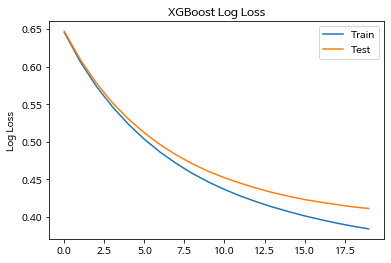

In [63]:
# 모델 성능 시각화

from matplotlib import pyplot
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
#pyplot.show()
plt.savefig('XGBoost Log Loss.png')

# 4. 우범화물 예측 및 모델 성능 평가 <a id='id4'></a>

## 4.1. XGBoost 모델 예측

In [64]:
# evaluate xgboost model
print("------Evaluating xgboost model------")
# Predict
test_pred = model.predict_proba(df_org_test)[:,1]
# Calculate auc
xgb_auc = roc_auc_score(org_test_y, test_pred)
print(xgb_auc)

------Evaluating xgboost model------
0.8340598506713636


## 4.2. 모델 예측 성능 평가

In [65]:
# 검사율에 따른 우범예측 함수 생성

def inspection_performance(predicted_fraud, test_fraud):
    
    # Set default values before a loop
    
    Inspect_Rate = []
    Precision=[]
    Recall=[]
    
    # Create a loop for making confusion matrix at each inspection rate

    for i in range(0,101,1):
        
        # Find the ith value in ascending order.
        threshold = np.percentile(predicted_fraud, i)
        # Precision = number of frauds / number of inspection
        precision = np.mean(test_fraud[predicted_fraud >= threshold])
        # Recall = number of inspected frauds / number of frauds
        recall = sum(test_fraud[predicted_fraud >= threshold])/sum(test_fraud)
        # Save values
        Inspect_Rate.append(100-i)
        Precision.append(precision)
        Recall.append(recall)
        
    
    compiled_conf_matrix = pd.DataFrame({
        
        'Inspect_Rate':Inspect_Rate,
        'Precision':Precision,
        'Recall':Recall
    })

    return compiled_conf_matrix

In [66]:
# 검사율에 따른 우범예측 
basic_performance = inspection_performance(test_pred, org_test_y.astype(float))

In [67]:
# 검사율 1~10% 지정 시 Precision 및 Recall 분석
# Precision (적중률) = (검사선별된 우범건수)/(검사선별 건수)
# Recall (적발률) = (검사선별된 우범건수) / (전체 우범건수)
basic_performance.iloc[range(99,89,-1),:]

,Inspect_Rate,Precision,Recall
99,1,0.844156,0.037058
98,2,0.785714,0.068985
97,3,0.800866,0.105473
96,4,0.805195,0.141391
95,5,0.792208,0.173888
94,6,0.776573,0.204105
93,7,0.762082,0.233751
92,8,0.739837,0.259407
91,9,0.723988,0.285633
90,10,0.708713,0.310718


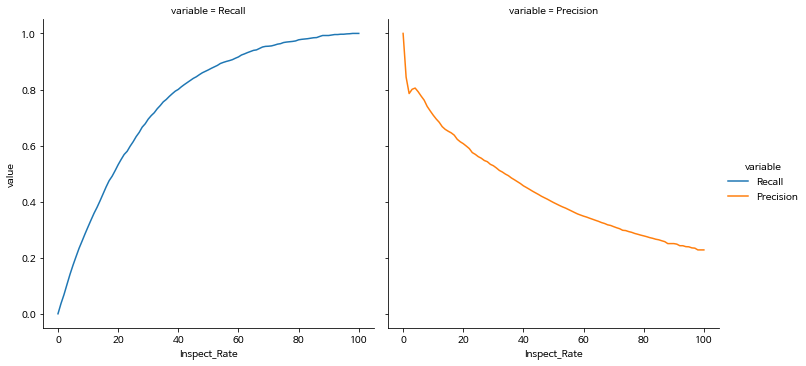

In [68]:
# 검사선별률에 따른 적중률 및 적발률 시각화
data = pd.melt(basic_performance, 
               id_vars = ['Inspect_Rate'],
               value_vars = ['Recall','Precision'])

sns.relplot(data=data,
            kind='line',
            x="Inspect_Rate", 
            y="value", 
            hue='variable',
            col="variable")
plt.savefig('recall & precision.png')


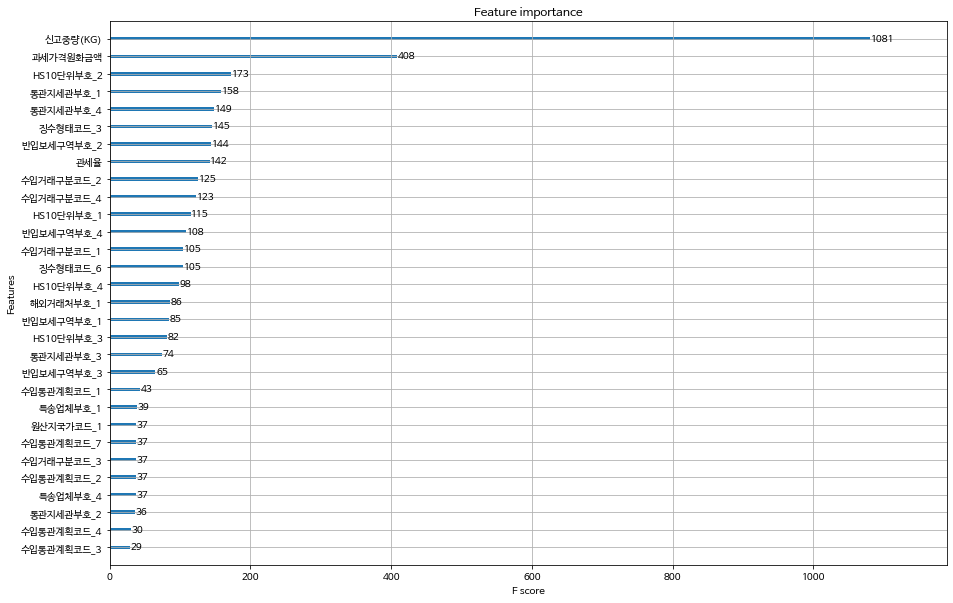

In [69]:
# 모델에 기여도가 높은 변수 시각화
from xgboost import plot_importance
plt.rcParams["font.family"] = 'NanumBarunGothic'
plt.rcParams["figure.figsize"] = (15,10)
plot_importance(model, max_num_features=30)
plt.show()

In [70]:
# 모델 종료 시간 확인
end = time.time()
# 모델 구동 시간 계산
print(f"모델구동시간 : {end-start} sec.")

모델구동시간 : 394.0467038154602 sec.


In [71]:
result = model.predict(df_org_for_prd)
submission = pd.read_csv('/submission.csv',encoding='utf-8', index_col='신고번호')
submission['우범여부'] = result
submission.to_csv('201802161_submission.csv')